# Задание на лабораторную работу 1

Необходимо для двух зависимых признаков оценить параметры регрессии с помощью МНК, подобрав экспериментально степень многочлена регрессии, посчитать коэффициент детерминации.

Для остатков проверить гипотезу об их гауссовости.

Добавить в выборку выбросы и оценить параметры регрессии с помощью МНК, Тьюки и Хьюбера.

В качестве признаков возьмем Индекс свободы прессы ([2021 World Press Freedom Index](https://rsf.org/en/ranking)) и Индекс человеческого развития ([Human Development Report 2020](https://report.hdr.undp.org/))

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Для получения данных об Индексе свободы прессы воспользуемся официальным сайтом https://rsf.org/en/ranking

In [2]:
session = requests.Session()
url = 'https://rsf.org/en/ranking'
headers = {
    "accept": "text/html,application/xhtml+xml,application/xml;" +
        "q=0.9,image/avif,image/webp,image/apng,"
        "*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36",
    "referer": 'https://rsf.org/en/ranking',
    "cookie": ""
}
response = session.request(
    'GET',
    url,
    headers = headers
)
print(len(response.text))

1358819


In [3]:
soup = BeautifulSoup(response.text, features="html.parser")

# данные по странам
countries_WPFI_list = soup.find_all("li", {"class": "country_name_item"})
countries = []
WPF_index = []

# собираем названия стран и соответствующие индексы
for countries_WPFI in countries_WPFI_list:
    country_name = countries_WPFI.find("span", {"class": "ranking-map__panel-name"}).text
    country_index = float(countries_WPFI.find("span", {"class": "ranking-map__panel-score"}).text)
    countries.append(country_name)
    WPF_index.append(country_index)

countries_WPFI_dict = {
    'country_name': countries,
    'WPF_index': WPF_index
}

# собираем датафрейм
country_index_df = pd.DataFrame(countries_WPFI_dict)
country_index_df.head()

,country_name,WPF_index
0,Norway,6.72
1,Finland,6.99
2,Sweden,7.24
3,Denmark,8.57
4,Costa Rica,8.76


In [4]:
country_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  180 non-null    object 
 1   WPF_index     180 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


Для получения данных об индексе человеческого развития воспользуемся Википедией, т.к. сайт ООН красивый, но непрактичный - https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index

In [5]:
session = requests.Session()
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index'

response = session.request(
    'GET',
    url,
    headers = headers
)
print(len(response.text))

520898


In [6]:
soup = BeautifulSoup(response.text, features="html.parser")

# данные по странам
HDI_table = soup.find("table").tbody
countries_HDI_list = HDI_table.find_all("tr")
countries = []
HumanDev_index = []

for countries_HDI in countries_HDI_list:
    try:
        country_name = countries_HDI.find("th").a.text
        country_index = float(countries_HDI.find_all("td")[-2].text)
        countries.append(country_name)
        HumanDev_index.append(country_index)
    except Exception:
        pass

countries_HDI_dict = {
    'country_name': countries,
    'HumanDev_index': HumanDev_index
}

# собираем датафрейм
country_HDI_df = pd.DataFrame(countries_HDI_dict)
country_HDI_df.head()

,country_name,HumanDev_index
0,Norway,0.957
1,Ireland,0.955
2,Switzerland,0.955
3,Hong Kong,0.949
4,Iceland,0.949


In [7]:
country_HDI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    189 non-null    object 
 1   HumanDev_index  189 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB


Объединяем данные из двух источников

In [8]:
combined_df = pd.merge(
    country_index_df,
    country_HDI_df,
    how="inner",
    on="country_name"
)
combined_df.sort_values(by='WPF_index', inplace=True)
combined_df.head()

,country_name,WPF_index,HumanDev_index
0,Norway,6.72,0.957
1,Finland,6.99,0.938
2,Sweden,7.24,0.945
3,Denmark,8.57,0.940
4,Costa Rica,8.76,0.810


In [9]:
combined_df.shape

(165, 3)

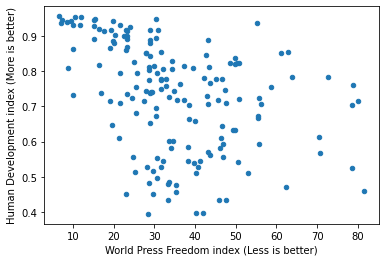

In [10]:
ax = combined_df.plot(
    x='WPF_index', 
    y='HumanDev_index', 
    kind='scatter', 
    xlabel='World Press Freedom index (Less is better)',
    ylabel='Human Development index (More is better)'
)
plt.show()

In [11]:
combined_df.corr()

,WPF_index,HumanDev_index
WPF_index,1.000000,-0.396891
HumanDev_index,-0.396891,1.000000


Стоит отметить не слишком высокую, но заметную отрицательную корреляцию

Постановка задачи:

Необходимо для двух зависимых признаков оценить параметры регрессии с помощью МНК,
подобрав экспериментально степень многочлена регрессии, посчитать коэффициент детерминации.

Для остатков проверить гипотезу об их гауссовости.
Оценить параметры регрессии с помощью МНК, Тьюки и Хьюбера.

In [24]:
def residuals_func(ps, y, x):
    return y - np.poly1d(ps)(x)


def huber_loss(ps, y, x, delta = 1.35):
    error = np.poly1d(ps)(x) - y
    is_small_error = np.abs(error) <= delta
    small_error_loss = np.square(error) / 2
    big_error_loss = delta * (np.abs(error) - 0.5*delta)
    return sum(np.where(is_small_error, small_error_loss, big_error_loss))


def tukey_loss(ps, y, x, delta = 4.7):
    error = np.poly1d(ps)(x) - y
    is_small_error = np.abs(error) <= delta
    small_error_loss = 1 - (1 - (error/delta)**2)**3
    return sum(np.where(is_small_error, small_error_loss, 1))

Оценка полиномом 1 степени:
R^2 = 2.220446049250313e-16
МНК:
y = 0.73x^0
Хьюбер:
y = 0.73x^0
Тьюки:
y = 0.73x^0


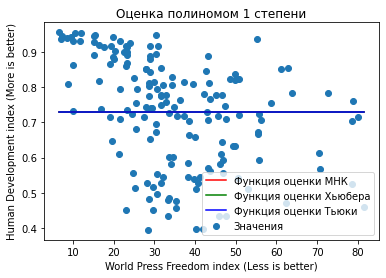

Оценка полиномом 2 степени:
R^2 = 0.15752207309732214
МНК:
y = 0.864x^0 + -0.004x^1
Хьюбер:
y = 0.864x^0 + -0.004x^1
Тьюки:
y = 0.864x^0 + -0.004x^1


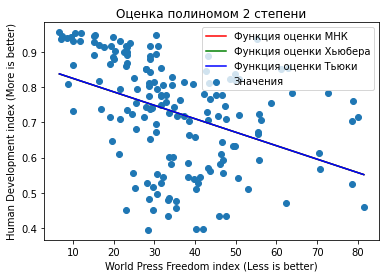

Оценка полиномом 3 степени:
R^2 = 0.23572831084433554
МНК:
y = 1.029x^0 + -0.014x^1 + 0.0x^2
Хьюбер:
y = 1.029x^0 + -0.014x^1 + 0.0x^2
Тьюки:
y = 1.029x^0 + -0.014x^1 + 0.0x^2


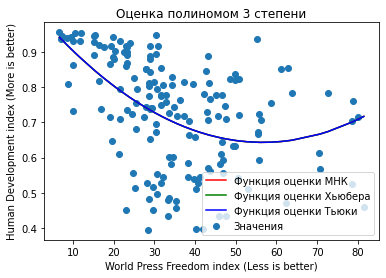

Оценка полиномом 4 степени:
R^2 = 0.25345890540429317
МНК:
y = 1.157x^0 + -0.027x^1 + 0.0x^2 + -0.0x^3
Хьюбер:
y = 1.223x^0 + -0.033x^1 + 0.001x^2 + -0.0x^3
Тьюки:
y = 1.256x^0 + -0.037x^1 + 0.001x^2 + -0.0x^3


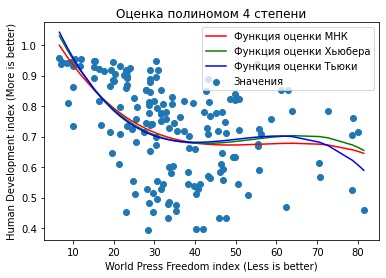

Оценка полиномом 5 степени:
R^2 = 0.2831088411221826
МНК:
y = 0.873x^0 + 0.017x^1 + -0.002x^2 + 0.0x^3 + -0.0x^4
Хьюбер:
y = 0.32x^0 + 0.107x^1 + -0.007x^2 + 0.0x^3 + -0.0x^4
Тьюки:
y = 0.0x^0 + 0.0x^1 + 0.0x^2 + 0.0x^3 + -0.0x^4


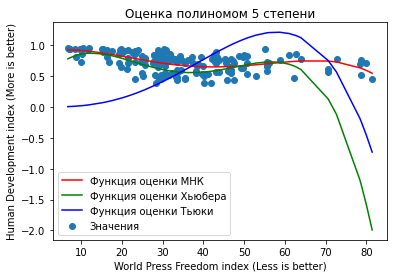

Оценка полиномом 6 степени:
R^2 = 0.28776650708102425
МНК:
y = 0.67x^0 + 0.057x^1 + -0.004x^2 + 0.0x^3 + -0.0x^4 + 0.0x^5
Хьюбер:
y = 0.0x^0 + 0.0x^1 + 0.0x^2 + 0.0x^3 + 0.0x^4 + 0.0x^5
Тьюки:
y = 0.0x^0 + 0.0x^1 + 0.0x^2 + 0.0x^3 + 0.0x^4 + 0.0x^5


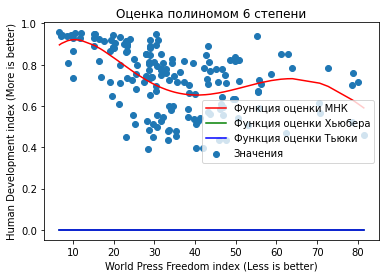

Оценка полиномом 7 степени:
R^2 = 0.2882437393723747
МНК:
y = 0.787x^0 + 0.029x^1 + -0.002x^2 + 0.0x^3 + 0.0x^4 + -0.0x^5 + 0.0x^6
Хьюбер:
y = 0.0x^0 + 0.0x^1 + 0.0x^2 + 0.0x^3 + 0.0x^4 + 0.0x^5 + 0.0x^6
Тьюки:
y = 0.0x^0 + 0.0x^1 + 0.0x^2 + 0.0x^3 + 0.0x^4 + 0.0x^5 + 0.0x^6


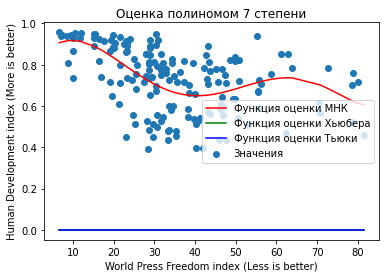

In [55]:
def calculate_least_squares(X, Y, poly_deg):
    """
    Функция находит оптимальные коэффициенты по методу
    наименьших квадратов (Aw = Y)
    """
    # матрица А
    A = np.array([
        [x_i**i for i in range(poly_deg)] for x_i in X
    ])
    # коэффиценты (решение системы)
    w = np.linalg.inv(A.T @ A) @ A.T @ Y
    F_y = A @ w
    # коэффицинт детерминации
    ss_tot = sum((y_i-np.mean(Y))**2 for y_i in Y)
    ss_err = sum((y_i-f_i)**2 for y_i, f_i in zip(Y, F_y))
    r2 = 1 - (ss_err/ss_tot)
    # оценка Хьюбера
    huber_res = minimize(huber_loss, [0]*poly_deg, args=(Y, X))['x'][::-1]
    # оценка Тьюки
    tukey_res = minimize(tukey_loss, [0]*poly_deg, args=(Y, X))['x'][::-1]
    # вывод в уравнения для Y в доступной форме
    print(f'Оценка полиномом {poly_deg} степени:')
    print(f'R^2 = {r2}')
    print('МНК:')
    print('y =', ' + '.join([f'{round(w[i], 3)}x^{i}' for i in range(poly_deg)]))
    print('Хьюбер:')
    print('y =', ' + '.join([f'{round(huber_res[i], 3)}x^{i}' for i in range(poly_deg)]))
    print('Тьюки:')
    print('y =', ' + '.join([f'{round(tukey_res[i], 3)}x^{i}' for i in range(poly_deg)]))
#     plt.xlim([5, 85])
#     plt.ylim([0.35, 1.05])
    plt.scatter(X, Y, label='Значения')
    
    plt.plot(X, A @ w, 'r', label='Функция оценки МНК')
    plt.plot(X, A @ huber_res, 'g', label='Функция оценки Хьюбера')
    plt.plot(X, A @ tukey_res, 'b', label='Функция оценки Тьюки')
    
    plt.title(f'Оценка полиномом {poly_deg} степени')
    plt.xlabel('World Press Freedom index (Less is better)')
    plt.ylabel('Human Development index (More is better)')
    plt.legend()
    plt.show()

# значения оси Х - индекс свободы прессы
X = np.array(combined_df.WPF_index.to_list())

# значения по оси Y - индекс развития
Y = np.array(combined_df.HumanDev_index.to_list())

for poly_num in range(1, 8):
    calculate_least_squares(X, Y, poly_num)

(array([ 4., 18., 30., 32., 21., 18., 15., 12., 11.,  4.]),
 array([-0.26350823, -0.20427065, -0.14503307, -0.08579549, -0.02655792,
         0.03267966,  0.09191724,  0.15115482,  0.2103924 ,  0.26962998,
         0.32886756]),
 <BarContainer object of 10 artists>)

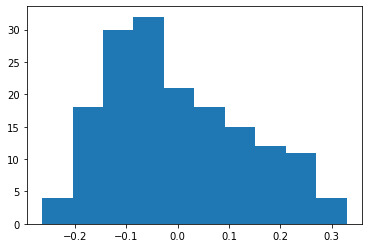

In [162]:
plt.hist(F_y - Y)

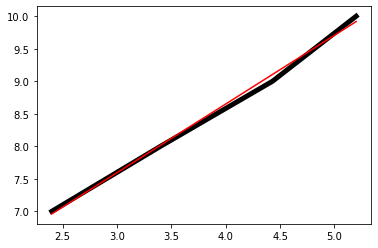

In [141]:
def polynom_f(x, deg):
    """
    Функция создания полинома степени deg и вычисления 
    его значений [х^0, x^1, ..., x^(deg-1)]
    """
    return [x**i for i in range(deg)]


X = [2.4, 3.4, 4.43, 5.2]
Y = [7, 8, 9, 10]

poly_deg = 2
A = np.array([polynom_f(x_i, poly_deg) for x_i in X])

w = np.linalg.inv(A.T @ A) @ A.T @ Y
plt.plot(X, Y, 'k', linewidth=5)
plt.plot(X, [sum(w*polynom_f(x_i, poly_deg)) for x_i in X], 'r')